<a href="https://colab.research.google.com/github/melinadwisafitri/skripsi_price_predict/blob/main/minyak_goreng_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Library

In [ ]:
import urllib.request
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import math

from keras.utils.vis_utils import plot_model
from tensorflow.data import Dataset
from tensorflow.keras.losses import Huber
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout
from tensorflow.keras.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, RootMeanSquaredError

## time step generator

In [ ]:
def time_step_generator(data, time_size, batch_size, shuffle_data):
  dataset = Dataset.from_tensor_slices(data)
  dataset = dataset.window(time_size+1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda x: x.batch(time_size+1))
  dataset = dataset.shuffle(shuffle_data)
  dataset = dataset.map(lambda x: (x[:-1], x[-1]))
  return dataset.batch(batch_size).prefetch(1)

def forecast_predict(model, data, time_size, batch_size):
  generate_data = Dataset.from_tensor_slices(data)
  add_window_step = generate_data.window(time_size, shift=1, drop_remainder=True)
  flatten_window = add_window_step.flat_map(lambda window: window.batch(time_size))
  batch_window = flatten_window.batch(batch_size).prefetch(1)
  model_predict = model.predict(batch_window)
  return model_predict

## Load data

In [ ]:
url ='https://github.com/melinadwisafitri/skripsi_price_predict/blob/main/data_pangan/data_fixs/data_new.csv?raw=true'
urllib.request.urlretrieve(url, 'data_pangan.csv')

('data_pangan.csv', <http.client.HTTPMessage at 0x7f8b09d54a00>)

In [ ]:
dataset = pd.read_csv('data_pangan.csv')
dataset.head()

,date,beras,beras_kualitas_bawah_i,beras_kualitas_bawah_ii,beras_kualitas_medium_i,beras_kualitas_medium_ii,beras_kualitas_super_i,beras_kualitas_super_ii,daging_ayam_ras_segar,daging_sapi_kualitas_1,...,cabai_rawit,cabai_rawit_hijau,cabai_rawit_merah,minyak_goreng,minyak_goreng_curah,minyak_goreng_kemasan_bermerk_1,minyak_goreng_kemasan_bermerk_2,gula_pasir,gula_pasir_kualitas_premium,gula_pasir_lokal
0,2017-01-08,11200,10150,9650,11250,11150,12750,12250,34100,118400,...,41050,34800,47550,13950,12250,15050,14350,14900,16800,13250
1,2017-01-11,11400,10350,9900,11500,11300,12900,12350,30350,117000,...,30000,30000,30450,13900,12250,14950,14300,14500,16550,12900
2,2017-01-12,10700,9650,8500,11200,10950,12250,11850,29350,115800,...,33300,31500,35050,14000,12150,15400,14400,14800,16650,12950
3,2017-02-08,11200,10150,9650,11250,11150,12750,12250,34150,118400,...,40600,34600,46650,13950,12250,15050,14350,14900,16800,13250
4,2017-02-10,11400,10250,9850,11400,11250,12850,12350,30200,118400,...,31850,32550,31550,14000,12350,15000,14350,14700,16750,12950


In [ ]:
dataset['date'] = pd.to_datetime(dataset['date'])

In [ ]:
dataset = dataset.set_index('date')
dataset = dataset.sort_index()
train = dataset.minyak_goreng.values
date = dataset.index

## Train test val split

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(train, date, test_size=0.2, random_state=False, shuffle=False)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.125, random_state=False, shuffle=False) # 0.125 x 0.48 = 0.1

print(f'{len(x_train)}\n{len(x_test)}')

818
234


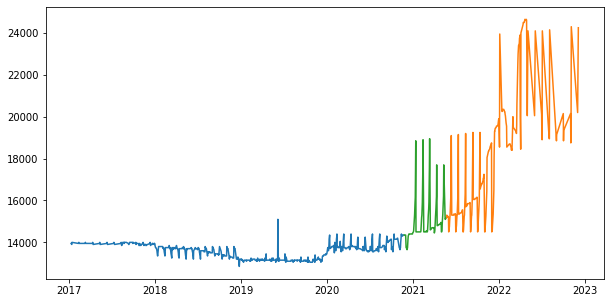

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(y_train, x_train)
plt.plot(y_test, x_test)
plt.plot(y_val, x_val)
plt.show()

## data generate

In [ ]:
scal_range= MinMaxScaler(feature_range=(0,1))
train_scal = scal_range.fit_transform(x_train.reshape(-1, 1))
test_scal = scal_range.fit_transform(x_test.reshape(-1, 1))
val_scal = scal_range.fit_transform(x_val.reshape(-1, 1))
train_step = time_step_generator(train_scal, time_size=600, shuffle_data=100, batch_size=5)
val_step = time_step_generator(val_scal, time_size=80, shuffle_data=100, batch_size=20)
test_step = time_step_generator(test_scal, time_size=150, shuffle_data=1000, batch_size=5)

train_step1 = time_step_generator(train_scal, time_size=100, shuffle_data=100, batch_size=1)
val_step1 = time_step_generator(val_scal, time_size=1, shuffle_data=10, batch_size=1)
test_step1 = time_step_generator(test_scal, time_size=10, shuffle_data=100, batch_size=1)

train_step2 = time_step_generator(train_scal, time_size=400, shuffle_data=1000, batch_size=5)
val_step2 = time_step_generator(val_scal, time_size=50, shuffle_data=100, batch_size=2)
test_step2 = time_step_generator(test_scal, time_size=100, shuffle_data=1000, batch_size=5)

In [ ]:
forecast = np.append(x_train, x_test)
forecast_date = np.append(y_train, y_test)
win_size= 400
win_size1 = 60
win_size2=150
test_minyakgoreng_ = scal_range.fit_transform(forecast.reshape(-1, 1))

## model 

### SGD

In [ ]:
model= Sequential([
    Conv1D(16, kernel_size=2, activation='relu',padding='causal', strides=2, input_shape=[None, 1]),
    LSTM(24, return_sequences=True),
    LSTM(20),
    Dense(64, activation='relu'),
    Dense(1)
])

model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9), loss='mse', metrics=['mae', 'mape'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 16)          48        
                                                                 
 lstm (LSTM)                 (None, None, 24)          3936      
                                                                 
 lstm_1 (LSTM)               (None, 20)                3600      
                                                                 
 dense (Dense)               (None, 64)                1344      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 8,993
Trainable params: 8,993
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# plot_model(model, to_file='model1_plot.png', show_shapes=True, show_layer_names=True)

#### type1

In [ ]:
history = model.fit(train_step, epochs=30, validation_data=val_step)

Epoch 1/30
44/44 [==============================] - 19s 47ms/step - loss: 0.1964 - mae: 0.4316 - mape: 97.5937 - val_loss: 0.0693 - val_mae: 0.2235 - val_mape: 78.2735
Epoch 2/30
44/44 [==============================] - 1s 21ms/step - loss: 0.1417 - mae: 0.3620 - mape: 80.9442 - val_loss: 0.0471 - val_mae: 0.1661 - val_mape: 54.1076
Epoch 3/30
44/44 [==============================] - 1s 20ms/step - loss: 0.1051 - mae: 0.3076 - mape: 68.0821 - val_loss: 0.0330 - val_mae: 0.1167 - val_mape: 33.4397
Epoch 4/30
44/44 [==============================] - 1s 21ms/step - loss: 0.0781 - mae: 0.2593 - mape: 56.5177 - val_loss: 0.0245 - val_mae: 0.0860 - val_mape: 23.3033
Epoch 5/30
44/44 [==============================] - 1s 20ms/step - loss: 0.0575 - mae: 0.2169 - mape: 46.5521 - val_loss: 0.0206 - val_mae: 0.0789 - val_mape: 23.6555
Epoch 6/30
44/44 [==============================] - 1s 20ms/step - loss: 0.0432 - mae: 0.1806 - mape: 37.8900 - val_loss: 0.0195 - val_mae: 0.0906 - val_mape: 31.58

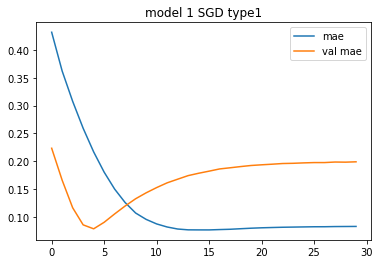

In [ ]:
mae = history.history['mae']
val_mae = history.history['val_mae']
epoch = range(len(mae))

plt.title('model 1 SGD type1')
plt.plot(epoch, mae, label='mae')
plt.plot(epoch, val_mae, label='val mae')
plt.legend()
plt.show()

131/131 [==============================] - 2s 8ms/step
2314.6113 12.785715 2795.995529324037


,date,actual,prediction
0,2021-05-20,15150,17852.671875
1,2021-05-21,15150,17855.175781
2,2021-05-24,15300,17853.925781
3,2021-05-25,15200,17859.132812
4,2021-05-27,15200,17857.750000
...,...,...,...
229,2022-11-02,18750,18147.478516
230,2022-11-03,19350,18197.212891
231,2022-11-04,24300,18146.148438
232,2022-12-01,20200,18186.365234


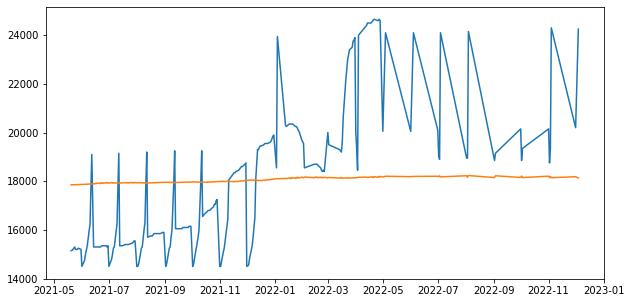

In [ ]:
prediction = forecast_predict(model, test_minyakgoreng_, time_size=win_size, batch_size=5)

data_result = prediction[(len(x_train))-win_size:-1, -1 ]
data_result = scal_range.inverse_transform(data_result.reshape(-1, 1))
data_result = data_result.reshape(-1)
mae= tf.keras.metrics.mean_absolute_error(x_test, data_result)
mape = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result)
mse = tf.keras.metrics.mean_squared_error(x_test, data_result)

rmse =math.sqrt(mse.numpy())
print(mae.numpy(), mape.numpy(), rmse)

data_new_minyakgoreng = pd.DataFrame()
data_new_minyakgoreng['date'] = y_test
data_new_minyakgoreng['actual'] = x_test
data_new_minyakgoreng['prediction'] = data_result
data_new_minyakgoreng.to_csv('minyakgoreng_model1_sgd_type1.csv')

plt.figure(figsize=(10, 5))
plt.plot(data_new_minyakgoreng.date, data_new_minyakgoreng.actual)
plt.plot(data_new_minyakgoreng.date, data_new_minyakgoreng.prediction)
data_new_minyakgoreng

#### type2

In [ ]:
history_t1 = model.fit(train_step1, epochs=30, validation_data=val_step)

Epoch 1/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0223 - mae: 0.1236 - mape: 435614.7812 - val_loss: 0.0241 - val_mae: 0.1320 - val_mape: 54.3165
Epoch 2/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0196 - mae: 0.1152 - mape: 334003.5312 - val_loss: 0.0242 - val_mae: 0.1324 - val_mape: 54.5005
Epoch 3/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0190 - mae: 0.1130 - mape: 403892.8438 - val_loss: 0.0245 - val_mae: 0.1340 - val_mape: 55.3364
Epoch 4/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0190 - mae: 0.1129 - mape: 458878.0312 - val_loss: 0.0242 - val_mae: 0.1326 - val_mape: 54.6175
Epoch 5/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0184 - mae: 0.1103 - mape: 435192.1250 - val_loss: 0.0244 - val_mae: 0.1332 - val_mape: 54.9237
Epoch 6/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0182 - mae: 0.1092 - mape: 415603.7500 - val_loss: 0.0245 - val_

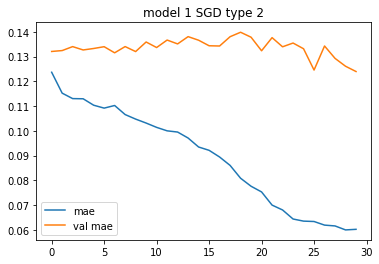

In [ ]:
mae_t1 = history_t1.history['mae']
val_mae_t1 = history_t1.history['val_mae']
epoch_t1 = range(len(mae_t1))

plt.title('model 1 SGD type 2')
plt.plot(epoch_t1, mae_t1, label='mae')
plt.plot(epoch_t1, val_mae_t1, label='val mae')
plt.legend()
plt.show()

199/199 [==============================] - 1s 4ms/step
1455.1367 7.4959254 2066.385128672775


,date,actual,prediction
0,2021-05-20,15150,17852.671875
1,2021-05-21,15150,17855.175781
2,2021-05-24,15300,17853.925781
3,2021-05-25,15200,17859.132812
4,2021-05-27,15200,17857.750000
...,...,...,...
229,2022-11-02,18750,18147.478516
230,2022-11-03,19350,18197.212891
231,2022-11-04,24300,18146.148438
232,2022-12-01,20200,18186.365234


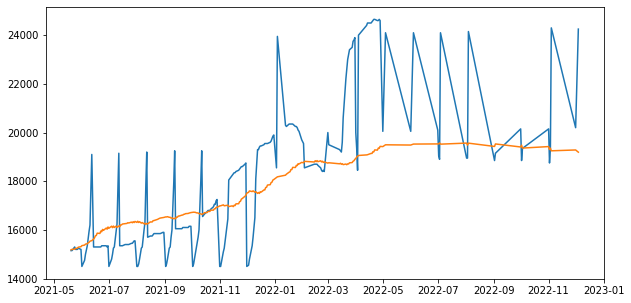

In [ ]:
win_size1 = 60
test_minyakgoreng_1 = scal_range.fit_transform(forecast.reshape(-1, 1))
prediction_1 = forecast_predict(model, test_minyakgoreng_1, time_size=win_size1, batch_size=5)

data_result_1 = prediction_1[(len(x_train))-win_size1:-1, -1 ]
data_result_1 = scal_range.inverse_transform(data_result_1.reshape(-1, 1))
data_result_1 = data_result_1.reshape(-1)
mae_1= tf.keras.metrics.mean_absolute_error(x_test, data_result_1)
mape_1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result_1)
mse_1 = tf.keras.metrics.mean_squared_error(x_test, data_result_1)
rmse_1 =math.sqrt(mse_1.numpy())
print(mae_1.numpy(), mape_1.numpy(), rmse_1)

data_new_minyakgoreng_1 = pd.DataFrame()
data_new_minyakgoreng_1['actual'] = x_test
data_new_minyakgoreng_1['prediction'] = data_result_1
data_new_minyakgoreng_1.to_csv('minyakgoreng_model1_sgd_type2.csv')

plt.figure(figsize=(10, 5))
plt.plot(y_test, data_new_minyakgoreng_1.actual)
plt.plot(y_test, data_new_minyakgoreng_1.prediction)
data_new_minyakgoreng

#### type3

In [ ]:
history_t2 = model.fit(train_step2, epochs=30, validation_data=val_step)

Epoch 1/30
84/84 [==============================] - 2s 17ms/step - loss: 0.0108 - mae: 0.0822 - mape: 39.8632 - val_loss: 0.0214 - val_mae: 0.1096 - val_mape: 41.8619
Epoch 2/30
84/84 [==============================] - 1s 15ms/step - loss: 0.0102 - mae: 0.0756 - mape: 34.1583 - val_loss: 0.0210 - val_mae: 0.1047 - val_mape: 39.0903
Epoch 3/30
84/84 [==============================] - 1s 15ms/step - loss: 0.0100 - mae: 0.0730 - mape: 31.6765 - val_loss: 0.0208 - val_mae: 0.1026 - val_mape: 37.8917
Epoch 4/30
84/84 [==============================] - 1s 15ms/step - loss: 0.0099 - mae: 0.0724 - mape: 31.1725 - val_loss: 0.0209 - val_mae: 0.1036 - val_mape: 38.4502
Epoch 5/30
84/84 [==============================] - 1s 15ms/step - loss: 0.0099 - mae: 0.0717 - mape: 30.5417 - val_loss: 0.0210 - val_mae: 0.1047 - val_mape: 39.0248
Epoch 6/30
84/84 [==============================] - 1s 15ms/step - loss: 0.0098 - mae: 0.0720 - mape: 30.9060 - val_loss: 0.0209 - val_mae: 0.1038 - val_mape: 38.521

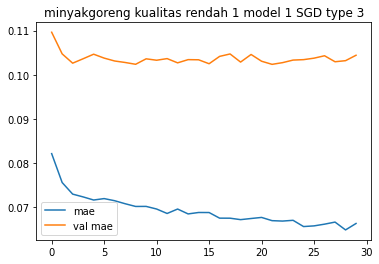

In [ ]:
mae_t2 = history_t2.history['mae']
val_mae_t2 = history_t2.history['val_mae']
epoch_t2 = range(len(mae_t2))

plt.title('minyakgoreng kualitas rendah 1 model 1 SGD type 3')
plt.plot(epoch_t2, mae_t2, label='mae')
plt.plot(epoch_t2, val_mae_t2, label='val mae')
plt.legend()
plt.show()

181/181 [==============================] - 1s 5ms/step
1343.1621 6.801629 1968.0974950443892


,actual,prediction
0,15150,14414.446289
1,15150,14427.886719
2,15300,14441.319336
3,15200,14469.054688
4,15200,14489.504883
...,...,...
229,18750,19663.621094
230,19350,19715.302734
231,24300,19600.185547
232,20200,19632.638672


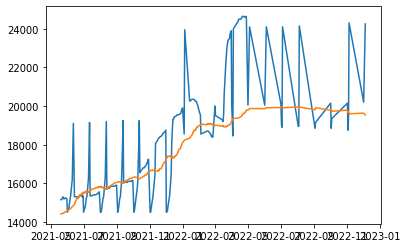

In [ ]:
win_size2 = 150
prediction_2 = forecast_predict(model, test_minyakgoreng_, time_size=win_size2, batch_size=5)

data_result_2 = prediction_2[(len(x_train))-win_size2:-1, -1 ]
data_result_2 = scal_range.inverse_transform(data_result_2.reshape(-1, 1))
data_result_2 = data_result_2.reshape(-1)
mae_2= tf.keras.metrics.mean_absolute_error(x_test, data_result_2)
mape_2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result_2)
mse_2 = tf.keras.metrics.mean_squared_error(x_test, data_result_2)

rmse_2 =math.sqrt(mse_2.numpy())
print(mae_2.numpy(), mape_2.numpy(), rmse_2)

data_new_minyakgoreng_2 = pd.DataFrame()
# data_new_minyakgoreng1['date'] = date_test
data_new_minyakgoreng_2['actual'] = x_test
data_new_minyakgoreng_2['prediction'] = data_result_2
data_new_minyakgoreng_2.to_csv('minyakgoreng_model1_sgd_type3')

plt.plot(y_test, data_new_minyakgoreng_2.actual)
plt.plot(y_test, data_new_minyakgoreng_2.prediction)
data_new_minyakgoreng_2

### Adam

In [ ]:
model_a= Sequential([
    Conv1D(16, kernel_size=2, activation='relu',padding='causal', strides=2, input_shape=[None, 1]),
        LSTM(24, return_sequences=True),
        LSTM(20),
        Dense(64, activation='relu'),
        Dense(1)
])

model_a.compile(loss= 'mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), metrics=['mae', 'mape'])
model_a.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, None, 16)          48        
                                                                 
 lstm_2 (LSTM)               (None, None, 24)          3936      
                                                                 
 lstm_3 (LSTM)               (None, 20)                3600      
                                                                 
 dense_2 (Dense)             (None, 64)                1344      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 8,993
Trainable params: 8,993
Non-trainable params: 0
_________________________________________________________________


#### Type 1

In [ ]:
history_a = model_a.fit(train_step, epochs=30, validation_data=val_step)

Epoch 1/30
44/44 [==============================] - 4s 38ms/step - loss: 0.1474 - mae: 0.3701 - mape: 83.1476 - val_loss: 0.0460 - val_mae: 0.1624 - val_mape: 52.4535
Epoch 2/30
44/44 [==============================] - 1s 20ms/step - loss: 0.0547 - mae: 0.2072 - mape: 45.2180 - val_loss: 0.0213 - val_mae: 0.1138 - val_mape: 44.5510
Epoch 3/30
44/44 [==============================] - 1s 20ms/step - loss: 0.0111 - mae: 0.0870 - mape: 19.8626 - val_loss: 0.0289 - val_mae: 0.1513 - val_mape: 64.3966
Epoch 4/30
44/44 [==============================] - 1s 21ms/step - loss: 0.0116 - mae: 0.0890 - mape: 20.0065 - val_loss: 0.0313 - val_mae: 0.1600 - val_mape: 68.8012
Epoch 5/30
44/44 [==============================] - 1s 21ms/step - loss: 0.0113 - mae: 0.0895 - mape: 20.2325 - val_loss: 0.0288 - val_mae: 0.1510 - val_mape: 64.2738
Epoch 6/30
44/44 [==============================] - 1s 20ms/step - loss: 0.0111 - mae: 0.0881 - mape: 20.0062 - val_loss: 0.0304 - val_mae: 0.1569 - val_mape: 67.263

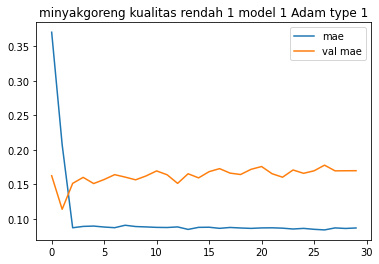

In [ ]:
mae_a = history_a.history['mae']
val_mae_a = history_a.history['val_mae']
epoch_a = range(len(mae_a))

plt.title('minyakgoreng kualitas rendah 1 model 1 Adam type 1')
plt.plot(epoch_a, mae_a, label='mae')
plt.plot(epoch_a, val_mae_a, label='val mae')
plt.legend()
plt.show()

131/131 [==============================] - 2s 8ms/step
1752.5599 9.621922 2150.210687351358


,actual,prediction
0,15150,16578.197266
1,15150,16585.476562
2,15300,16590.152344
3,15200,16604.785156
4,15200,16610.964844
...,...,...
229,18750,19902.437500
230,19350,19979.265625
231,24300,19848.648438
232,20200,19906.308594


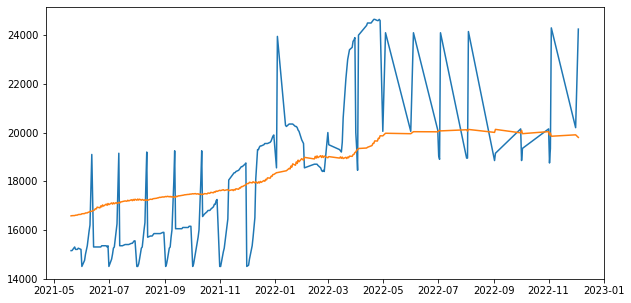

In [ ]:
prediction_a = forecast_predict(model_a, test_minyakgoreng_, time_size=win_size, batch_size=5)

data_result_a = prediction_a[(len(x_train))-win_size:-1, -1 ]
data_result_a = scal_range.inverse_transform(data_result_a.reshape(-1, 1))
data_result_a = data_result_a.reshape(-1)
mae_a= tf.keras.metrics.mean_absolute_error(x_test, data_result_a)
mape_a = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result_a)
mse_a = tf.keras.metrics.mean_squared_error(x_test, data_result_a)

rmse_a =math.sqrt(mse_a.numpy())
print(mae_a.numpy(), mape_a.numpy(), rmse_a)

data_new_minyakgoreng_a = pd.DataFrame()
# data_new_minyakgoreng1['date'] = date_test
data_new_minyakgoreng_a['actual'] = x_test
data_new_minyakgoreng_a['prediction'] = data_result_a
data_new_minyakgoreng_a.to_csv('minyakgoreng_model1_adam_type1.csv')

plt.figure(figsize=(10,5))
plt.plot(y_test, data_new_minyakgoreng_a.actual)
plt.plot(y_test, data_new_minyakgoreng_a.prediction)
data_new_minyakgoreng_a

#### Type 2

In [ ]:
history_a1 = model_a.fit(train_step1, epochs=30, validation_data=val_step)

Epoch 1/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0087 - mae: 0.0683 - mape: 408026.4688 - val_loss: 0.0214 - val_mae: 0.1125 - val_mape: 43.6347
Epoch 2/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0074 - mae: 0.0594 - mape: 307038.5000 - val_loss: 0.0231 - val_mae: 0.1239 - val_mape: 49.7077
Epoch 3/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0072 - mae: 0.0591 - mape: 335263.9062 - val_loss: 0.0207 - val_mae: 0.1004 - val_mape: 36.6911
Epoch 4/30
718/718 [==============================] - 6s 9ms/step - loss: 0.0070 - mae: 0.0577 - mape: 322721.3438 - val_loss: 0.0216 - val_mae: 0.1112 - val_mape: 42.6603
Epoch 5/30
718/718 [==============================] - 6s 9ms/step - loss: 0.0071 - mae: 0.0577 - mape: 325196.3125 - val_loss: 0.0208 - val_mae: 0.0920 - val_mape: 31.5061
Epoch 6/30
718/718 [==============================] - 6s 9ms/step - loss: 0.0069 - mae: 0.0561 - mape: 308411.7500 - val_loss: 0.0207 - val_

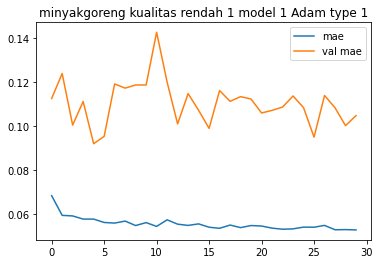

In [ ]:
mae_a1 = history_a1.history['mae']
val_mae_a1 = history_a1.history['val_mae']
epoch_a1 = range(len(mae_a1))

plt.title('minyakgoreng kualitas rendah 1 model 1 Adam type 1')
plt.plot(epoch_a1, mae_a1, label='mae')
plt.plot(epoch_a1, val_mae_a1, label='val mae')
plt.legend()
plt.show()

199/199 [==============================] - 1s 4ms/step
1382.9556 7.3457913 1779.3965269157968


,actual,prediction
0,15150,14476.893555
1,15150,14490.349609
2,15300,14530.115234
3,15200,14567.997070
4,15200,14623.723633
...,...,...
229,18750,20766.966797
230,19350,20540.701172
231,24300,20472.455078
232,20200,20280.451172


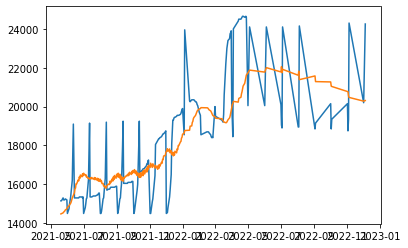

In [ ]:
prediction_a1 = forecast_predict(model_a, test_minyakgoreng_, time_size=win_size1, batch_size=5)

data_result_a1 = prediction_a1[(len(x_train))-win_size1:-1, -1 ]
data_result_a1 = scal_range.inverse_transform(data_result_a1.reshape(-1, 1))
data_result_a1 = data_result_a1.reshape(-1)
mae_a1= tf.keras.metrics.mean_absolute_error(x_test, data_result_a1)
mape_a1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result_a1)
mse_a1 = tf.keras.metrics.mean_squared_error(x_test, data_result_a1)

rmse_a1 =math.sqrt(mse_a1.numpy())
print(mae_a1.numpy(), mape_a1.numpy(), rmse_a1)

data_new_minyakgoreng_a1 = pd.DataFrame()
data_new_minyakgoreng_a1['actual'] = x_test
data_new_minyakgoreng_a1['prediction'] = data_result_a1
data_new_minyakgoreng_a1.to_csv('minyakgoreng_model1_adam_type2.csv')

plt.plot(y_test, data_new_minyakgoreng_a1.actual)
plt.plot(y_test, data_new_minyakgoreng_a1.prediction)
data_new_minyakgoreng_a1

#### Type 3

In [ ]:
history_a2 = model_a.fit(train_step2, epochs=30, validation_data=val_step)

Epoch 1/30
84/84 [==============================] - 2s 17ms/step - loss: 0.0074 - mae: 0.0560 - mape: 20.5514 - val_loss: 0.0221 - val_mae: 0.1017 - val_mape: 36.6566
Epoch 2/30
84/84 [==============================] - 1s 15ms/step - loss: 0.0073 - mae: 0.0535 - mape: 17.8603 - val_loss: 0.0221 - val_mae: 0.1033 - val_mape: 37.5868
Epoch 3/30
84/84 [==============================] - 1s 15ms/step - loss: 0.0073 - mae: 0.0540 - mape: 18.3922 - val_loss: 0.0222 - val_mae: 0.1046 - val_mape: 38.3151
Epoch 4/30
84/84 [==============================] - 1s 15ms/step - loss: 0.0074 - mae: 0.0554 - mape: 19.0932 - val_loss: 0.0225 - val_mae: 0.1105 - val_mape: 41.7284
Epoch 5/30
84/84 [==============================] - 1s 15ms/step - loss: 0.0074 - mae: 0.0540 - mape: 18.0577 - val_loss: 0.0222 - val_mae: 0.1062 - val_mape: 39.2454
Epoch 6/30
84/84 [==============================] - 1s 15ms/step - loss: 0.0074 - mae: 0.0557 - mape: 19.6712 - val_loss: 0.0220 - val_mae: 0.1010 - val_mape: 36.256

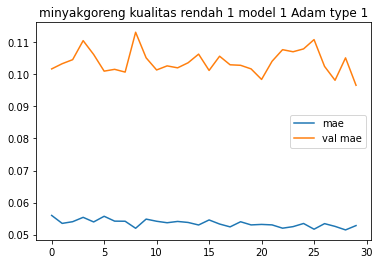

In [ ]:
mae_a2 = history_a2.history['mae']
val_mae_a2 = history_a2.history['val_mae']
epoch_a2 = range(len(mae_a2))

plt.title('minyakgoreng kualitas rendah 1 model 1 Adam type 1')
plt.plot(epoch_a2, mae_a2, label='mae')
plt.plot(epoch_a2, val_mae_a2, label='val mae')
plt.legend()
plt.show()

181/181 [==============================] - 1s 5ms/step
1426.4133 7.5320854 1841.350794932894


,actual,prediction
0,15150,14466.302734
1,15150,14470.678711
2,15300,14519.190430
3,15200,14552.494141
4,15200,14631.871094
...,...,...
229,18750,20563.082031
230,19350,20355.638672
231,24300,20301.539062
232,20200,20127.048828


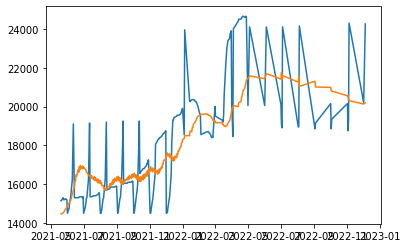

In [ ]:
prediction_a2 = forecast_predict(model_a, test_minyakgoreng_, time_size=win_size2, batch_size=5)

data_result_a2 = prediction_a2[(len(x_train))-win_size2:-1, -1 ]
data_result_a2 = scal_range.inverse_transform(data_result_a2.reshape(-1, 1))
data_result_a2 = data_result_a2.reshape(-1)
mae_a2= tf.keras.metrics.mean_absolute_error(x_test, data_result_a2)
mape_a2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result_a2)
mse_a2 = tf.keras.metrics.mean_squared_error(x_test, data_result_a2)

rmse_a2 =math.sqrt(mse_a2.numpy())
print(mae_a2.numpy(), mape_a2.numpy(), rmse_a2)

data_new_minyakgoreng_a2 = pd.DataFrame()
# data_new_minyakgoreng1['date'] = date_test
data_new_minyakgoreng_a2['actual'] = x_test
data_new_minyakgoreng_a2['prediction'] = data_result_a2
data_new_minyakgoreng_a2.to_csv('minyakgoreng_model1_adam_type3.csv')

plt.plot(y_test, data_new_minyakgoreng_a2.actual)
plt.plot(y_test, data_new_minyakgoreng_a2.prediction)
data_new_minyakgoreng_a2

## model 1

### Adam

In [ ]:
model1= Sequential([
    Conv1D(16, kernel_size=5, activation='relu', strides=2, input_shape=[None, 1], padding='causal'),
    LSTM(128, return_sequences=True),
    LSTM(32),
    Dense(64, activation='relu'),
    Dense(128, activation='relu'),
    Dense(1)
])

model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='mse', metrics=['mae', 'mape'])
model1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, None, 16)          96        
                                                                 
 lstm_4 (LSTM)               (None, None, 128)         74240     
                                                                 
 lstm_5 (LSTM)               (None, 32)                20608     
                                                                 
 dense_4 (Dense)             (None, 64)                2112      
                                                                 
 dense_5 (Dense)             (None, 128)               8320      
                                                                 
 dense_6 (Dense)             (None, 1)                 129       
                                                                 
Total params: 105,505
Trainable params: 105,505
Non-tr

#### Type 1

In [ ]:
history1 = model1.fit(train_step, epochs=15, validation_data=val_step)

Epoch 1/15
44/44 [==============================] - 5s 44ms/step - loss: 0.0956 - mae: 0.2798 - mape: 63.0755 - val_loss: 0.0271 - val_mae: 0.1437 - val_mape: 60.2378
Epoch 2/15
44/44 [==============================] - 1s 22ms/step - loss: 0.0138 - mae: 0.0982 - mape: 22.5361 - val_loss: 0.0280 - val_mae: 0.1471 - val_mape: 62.0145
Epoch 3/15
44/44 [==============================] - 1s 22ms/step - loss: 0.0123 - mae: 0.0906 - mape: 20.5973 - val_loss: 0.0276 - val_mae: 0.1455 - val_mape: 61.2159
Epoch 4/15
44/44 [==============================] - 1s 23ms/step - loss: 0.0122 - mae: 0.0908 - mape: 20.5317 - val_loss: 0.0271 - val_mae: 0.1433 - val_mape: 60.0396
Epoch 5/15
44/44 [==============================] - 1s 22ms/step - loss: 0.0114 - mae: 0.0868 - mape: 19.5738 - val_loss: 0.0311 - val_mae: 0.1579 - val_mape: 67.7326
Epoch 6/15
44/44 [==============================] - 1s 23ms/step - loss: 0.0119 - mae: 0.0908 - mape: 20.7882 - val_loss: 0.0254 - val_mae: 0.1358 - val_mape: 56.088

17/17 [==============================] - 0s 7ms/step - loss: 0.0561 - mae: 0.1937 - mape: 28.3622


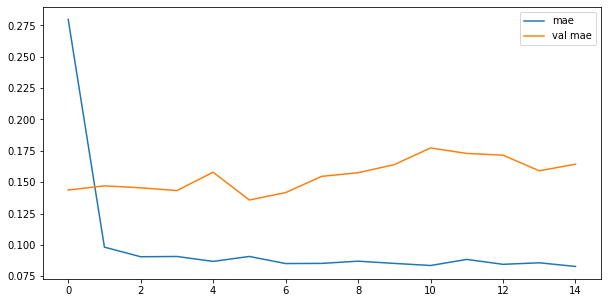

In [ ]:
model1.evaluate(test_step)
mae1 = history1.history['mae']
val_mae1 = history1.history['val_mae']
epoch1 = range(len(mae1))

plt.figure(figsize=(10, 5))
plt.plot(epoch1, mae1, label='mae')
plt.plot(epoch1, val_mae1, label='val mae')
plt.legend()
plt.show()

In [ ]:
prediction1 = forecast_predict(model1, test_minyakgoreng_, time_size=win_size, batch_size=5)

data_result1 = prediction1[(len(x_train))-win_size:-1, -1 ]
data_result1 = scal_range.inverse_transform(data_result1.reshape(-1, 1))
data_result1 = data_result1.reshape(-1)
mae1 = tf.keras.metrics.mean_absolute_error(x_test, data_result1)
mape1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1)
mse1 = tf.keras.metrics.mean_squared_error(x_test, data_result1)

rmse1 = math.sqrt(mse1.numpy())
print(mae1.numpy(), mape1.numpy(), rmse1)

data_new_minyakgoreng1 = pd.DataFrame()
data_new_minyakgoreng1['actual'] = x_test
data_new_minyakgoreng1['prediction'] = data_result1
data_new_minyakgoreng1.to_csv('minyakgoreng_model2_adam_type1.csv')

data_new_minyakgoreng1

131/131 [==============================] - 2s 8ms/step
1632.5833 8.954329 1991.335167670174


,actual,prediction
0,15150,16082.340820
1,15150,16083.642578
2,15300,16103.248047
3,15200,16104.661133
4,15200,16134.621094
...,...,...
229,18750,20509.101562
230,19350,20375.201172
231,24300,20393.349609
232,20200,20262.107422


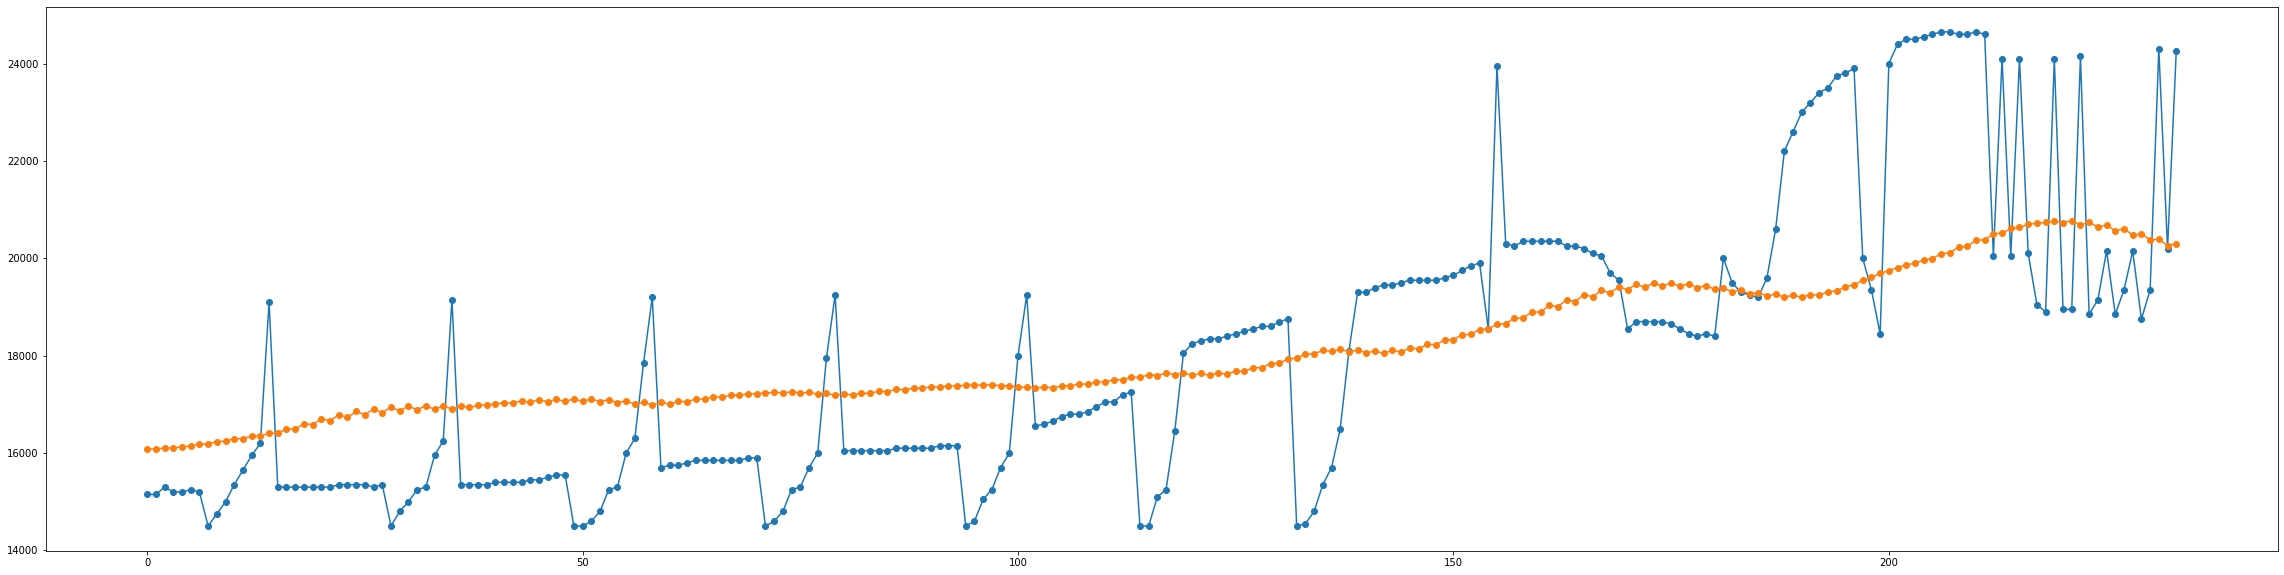

In [ ]:
plt.figure(figsize=(40, 10))
plt.plot(range(len(x_test)), data_new_minyakgoreng1['actual'], '-o')
plt.plot(range(len(x_test)), data_new_minyakgoreng1['prediction'], '-o')

#### Type 2

In [ ]:
history1_1 = model1.fit(train_step1, epochs=15, validation_data=val_step)

Epoch 1/15
718/718 [==============================] - 7s 9ms/step - loss: 0.0079 - mae: 0.0640 - mape: 332317.8125 - val_loss: 0.0211 - val_mae: 0.0997 - val_mape: 36.2671
Epoch 2/15
718/718 [==============================] - 7s 9ms/step - loss: 0.0070 - mae: 0.0570 - mape: 365208.8438 - val_loss: 0.0258 - val_mae: 0.1354 - val_mape: 55.6867
Epoch 3/15
718/718 [==============================] - 7s 9ms/step - loss: 0.0072 - mae: 0.0587 - mape: 318710.1875 - val_loss: 0.0225 - val_mae: 0.1139 - val_mape: 44.0578
Epoch 4/15
718/718 [==============================] - 7s 9ms/step - loss: 0.0071 - mae: 0.0577 - mape: 319793.7500 - val_loss: 0.0216 - val_mae: 0.1036 - val_mape: 38.3700
Epoch 5/15
718/718 [==============================] - 7s 9ms/step - loss: 0.0071 - mae: 0.0565 - mape: 367677.6250 - val_loss: 0.0214 - val_mae: 0.0889 - val_mape: 29.3546
Epoch 6/15
718/718 [==============================] - 7s 9ms/step - loss: 0.0070 - mae: 0.0565 - mape: 335033.8750 - val_loss: 0.0220 - val_

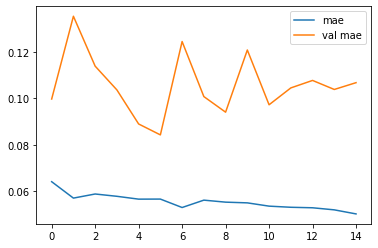

In [ ]:
mae1_1 = history1_1.history['mae']
val_mae1_1 = history1_1.history['val_mae']
epoch1_1 = range(len(mae1_1))

plt.plot(epoch1_1, mae1_1, label='mae')
plt.plot(epoch1_1, val_mae1_1, label='val mae')
plt.legend()
plt.show()

199/199 [==============================] - 1s 4ms/step
1364.79 7.3910832 1991.335167670174


,actual,prediction
0,15150,14611.076172
1,15150,14615.574219
2,15300,14646.215820
3,15200,14657.953125
4,15200,14708.103516
...,...,...
229,18750,21788.218750
230,19350,21476.160156
231,24300,20999.617188
232,20200,20668.277344


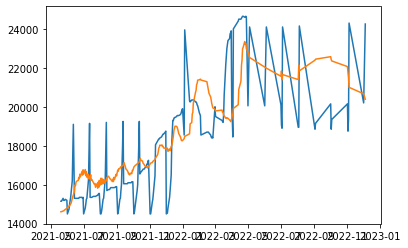

In [ ]:
prediction1_1 = forecast_predict(model1, test_minyakgoreng_, time_size=win_size1, batch_size=5)

data_result1_1 = prediction1_1[(len(x_train))-win_size1:-1, -1 ]
data_result1_1 = scal_range.inverse_transform(data_result1_1.reshape(-1, 1))
data_result1_1 = data_result1_1.reshape(-1)
mae1_1 = tf.keras.metrics.mean_absolute_error(x_test, data_result1_1)
mape1_1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1_1)
mse1_1 = tf.keras.metrics.mean_squared_error(x_test, data_result1_1)

rmse1_1 = math.sqrt(mse1.numpy())
print(mae1_1.numpy(), mape1_1.numpy(), rmse1_1)

data_new_minyakgoreng1_1 = pd.DataFrame()
data_new_minyakgoreng1_1['actual'] = x_test
data_new_minyakgoreng1_1['prediction'] = data_result1_1
data_new_minyakgoreng1_1.to_csv('minyakgoreng_model2_adam_type2.csv')

plt.plot(y_test, data_new_minyakgoreng1_1.actual)
plt.plot(y_test, data_new_minyakgoreng1_1.prediction)
data_new_minyakgoreng1_1

#### Type 3

In [ ]:
history1_2 = model1.fit(train_step2, epochs=15, validation_data=val_step)

Epoch 1/15
84/84 [==============================] - 2s 19ms/step - loss: 0.0072 - mae: 0.0525 - mape: 18.4996 - val_loss: 0.0193 - val_mae: 0.1030 - val_mape: 39.9538
Epoch 2/15
84/84 [==============================] - 2s 17ms/step - loss: 0.0069 - mae: 0.0514 - mape: 17.7644 - val_loss: 0.0190 - val_mae: 0.1001 - val_mape: 38.1654
Epoch 3/15
84/84 [==============================] - 2s 17ms/step - loss: 0.0069 - mae: 0.0515 - mape: 18.4094 - val_loss: 0.0199 - val_mae: 0.1091 - val_mape: 43.1815
Epoch 4/15
84/84 [==============================] - 2s 17ms/step - loss: 0.0068 - mae: 0.0511 - mape: 18.2024 - val_loss: 0.0188 - val_mae: 0.0976 - val_mape: 36.6077
Epoch 5/15
84/84 [==============================] - 2s 17ms/step - loss: 0.0069 - mae: 0.0498 - mape: 17.0882 - val_loss: 0.0191 - val_mae: 0.1003 - val_mape: 37.9789
Epoch 6/15
84/84 [==============================] - 2s 17ms/step - loss: 0.0067 - mae: 0.0508 - mape: 17.9819 - val_loss: 0.0187 - val_mae: 0.0942 - val_mape: 34.474

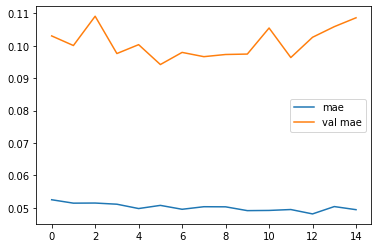

In [ ]:
mae1_2 = history1_2.history['mae']
val_mae1_2 = history1_2.history['val_mae']
epoch1_2 = range(len(mae1_2))

plt.plot(epoch1_2, mae1_2, label='mae')
plt.plot(epoch1_2, val_mae1_2, label='val mae')
plt.legend()
plt.show()

181/181 [==============================] - 1s 5ms/step
1430.8937 7.6855392 1991.335167670174


,actual,prediction
0,15150,14533.958984
1,15150,14549.748047
2,15300,14603.913086
3,15200,14628.009766
4,15200,14701.191406
...,...,...
229,18750,22293.656250
230,19350,21864.035156
231,24300,21427.847656
232,20200,20887.359375


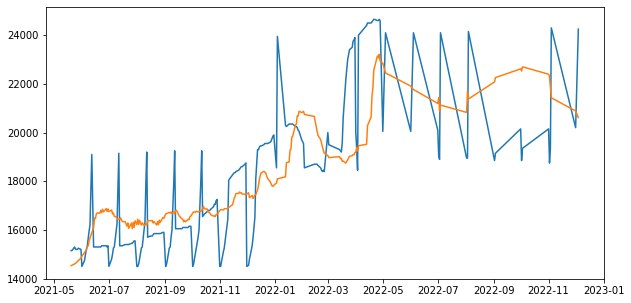

In [ ]:
prediction1_2 = forecast_predict(model1, test_minyakgoreng_, time_size=win_size2, batch_size=5)

data_result1_2 = prediction1_2[(len(x_train))-win_size2:-1, -1 ]
data_result1_2 = scal_range.inverse_transform(data_result1_2.reshape(-1, 1))
data_result1_2 = data_result1_2.reshape(-1)
mae1_2 = tf.keras.metrics.mean_absolute_error(x_test, data_result1_2)
mape1_2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1_2)
mse1_2 = tf.keras.metrics.mean_squared_error(x_test, data_result1_2)
rmse1_2 = math.sqrt(mse1.numpy())
print(mae1_2.numpy(), mape1_2.numpy(), rmse1_2)

data_new_minyakgoreng1_2 = pd.DataFrame()
data_new_minyakgoreng1_2['actual'] = x_test
data_new_minyakgoreng1_2['prediction'] = data_result1_2
data_new_minyakgoreng1_2.to_csv('minyakgoreng_model2_adam_type3.csv')

plt.figure(figsize=(10, 5))
plt.plot(y_test, data_new_minyakgoreng1_2.actual)
plt.plot(y_test, data_new_minyakgoreng1_2.prediction)

data_new_minyakgoreng1_2

### SGD

In [ ]:
model1_a= Sequential([
    Conv1D(16, kernel_size=5, activation='relu', strides=2, input_shape=[None, 1], padding='causal'),
    LSTM(128, return_sequences=True),
    LSTM(32),
    Dense(64, activation='relu'),
    Dense(128, activation='relu'),
    Dense(1)
])

model1_a.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9), loss='mse', metrics=['mae', 'mape'])
model1_a.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, None, 16)          96        
                                                                 
 lstm_6 (LSTM)               (None, None, 128)         74240     
                                                                 
 lstm_7 (LSTM)               (None, 32)                20608     
                                                                 
 dense_7 (Dense)             (None, 64)                2112      
                                                                 
 dense_8 (Dense)             (None, 128)               8320      
                                                                 
 dense_9 (Dense)             (None, 1)                 129       
                                                                 
Total params: 105,505
Trainable params: 105,505
Non-tr

In [ ]:
# plot_model(model1, to_file='model2_plot.png', show_shapes=True, show_layer_names=True)

#### Type1 

In [ ]:
history1_a = model1_a.fit(train_step, epochs=15, validation_data=val_step)

Epoch 1/15
44/44 [==============================] - 5s 48ms/step - loss: 0.1715 - mae: 0.4016 - mape: 90.4835 - val_loss: 0.0593 - val_mae: 0.1993 - val_mape: 68.0376
Epoch 2/15
44/44 [==============================] - 1s 22ms/step - loss: 0.1149 - mae: 0.3232 - mape: 71.8028 - val_loss: 0.0360 - val_mae: 0.1283 - val_mape: 38.1866
Epoch 3/15
44/44 [==============================] - 1s 23ms/step - loss: 0.0762 - mae: 0.2570 - mape: 56.1532 - val_loss: 0.0243 - val_mae: 0.0850 - val_mape: 22.9951
Epoch 4/15
44/44 [==============================] - 1s 23ms/step - loss: 0.0505 - mae: 0.2006 - mape: 42.7495 - val_loss: 0.0200 - val_mae: 0.0832 - val_mape: 26.7085
Epoch 5/15
44/44 [==============================] - 1s 23ms/step - loss: 0.0344 - mae: 0.1551 - mape: 31.9093 - val_loss: 0.0200 - val_mae: 0.1013 - val_mape: 37.6574
Epoch 6/15
44/44 [==============================] - 1s 23ms/step - loss: 0.0246 - mae: 0.1215 - mape: 24.1330 - val_loss: 0.0221 - val_mae: 0.1199 - val_mape: 47.847

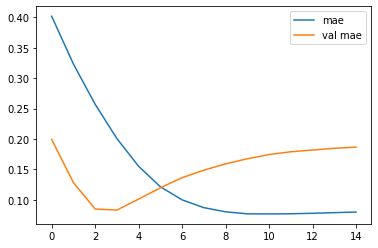

In [ ]:
mae1_a = history1_a.history['mae']
val_mae1_a = history1_a.history['val_mae']
epoch1_a = range(len(mae1_a))

plt.plot(epoch1_a, mae1_a, label='mae')
plt.plot(epoch1_a, val_mae1_a, label='val mae')
plt.legend()
plt.show()

131/131 [==============================] - 2s 8ms/step
2185.1604 11.988988 2664.8971837577524


,actual,prediction
0,15150,17518.363281
1,15150,17519.062500
2,15300,17524.748047
3,15200,17525.527344
4,15200,17532.480469
...,...,...
229,18750,18420.132812
230,19350,18381.962891
231,24300,18393.093750
232,20200,18362.738281


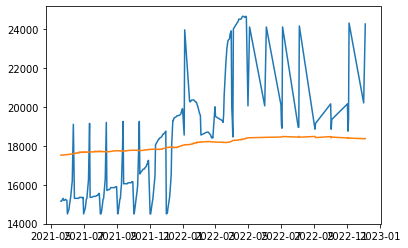

In [ ]:
prediction1_a = forecast_predict(model1_a, test_minyakgoreng_, time_size=win_size, batch_size=5)

data_result1_a = prediction1_a[(len(x_train))-win_size:-1, -1 ]
data_result1_a = scal_range.inverse_transform(data_result1_a.reshape(-1, 1))
data_result1_a = data_result1_a.reshape(-1)
mae1_a = tf.keras.metrics.mean_absolute_error(x_test, data_result1_a)
mape1_a = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1_a)
mse1_a = tf.keras.metrics.mean_squared_error(x_test, data_result1_a)

rmse1_a = math.sqrt(mse1_a.numpy())
print(mae1_a.numpy(), mape1_a.numpy(), rmse1_a)

data_new_minyakgoreng1_a = pd.DataFrame()
data_new_minyakgoreng1_a['actual'] = x_test
data_new_minyakgoreng1_a['prediction'] = data_result1_a
data_new_minyakgoreng1_a.to_csv('minyakgoreng_model2_sgd_type1.csv')


plt.plot(y_test, data_new_minyakgoreng1_a.actual)
plt.plot(y_test, data_new_minyakgoreng1_a.prediction)

data_new_minyakgoreng1_a

#### Type 2


In [ ]:
history1_a1 = model1_a.fit(train_step1, epochs=15, validation_data=val_step)

Epoch 1/15
718/718 [==============================] - 7s 9ms/step - loss: 0.0175 - mae: 0.1068 - mape: 418752.0000 - val_loss: 0.0282 - val_mae: 0.1490 - val_mape: 63.1349
Epoch 2/15
718/718 [==============================] - 7s 9ms/step - loss: 0.0155 - mae: 0.0983 - mape: 361962.9688 - val_loss: 0.0286 - val_mae: 0.1505 - val_mape: 63.9007
Epoch 3/15
718/718 [==============================] - 7s 9ms/step - loss: 0.0151 - mae: 0.0959 - mape: 425309.2500 - val_loss: 0.0283 - val_mae: 0.1494 - val_mape: 63.3006
Epoch 4/15
718/718 [==============================] - 7s 9ms/step - loss: 0.0142 - mae: 0.0935 - mape: 281033.4375 - val_loss: 0.0281 - val_mae: 0.1483 - val_mape: 62.7385
Epoch 5/15
718/718 [==============================] - 7s 9ms/step - loss: 0.0138 - mae: 0.0907 - mape: 391966.8750 - val_loss: 0.0277 - val_mae: 0.1467 - val_mape: 61.8549
Epoch 6/15
718/718 [==============================] - 7s 9ms/step - loss: 0.0129 - mae: 0.0869 - mape: 307387.6875 - val_loss: 0.0279 - val_

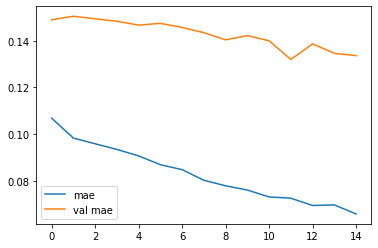

In [ ]:
mae1_a1 = history1_a1.history['mae']
val_mae1_a1 = history1_a1.history['val_mae']
epoch1_a1 = range(len(mae1_a1))

plt.plot(epoch1_a1, mae1_a1, label='mae')
plt.plot(epoch1_a1, val_mae1_a1, label='val mae')
plt.legend()
plt.show()

199/199 [==============================] - 1s 4ms/step
1539.5687 8.021234 2117.96470697696


,actual,prediction
0,15150,15551.458008
1,15150,15553.872070
2,15300,15573.019531
3,15200,15578.248047
4,15200,15604.535156
...,...,...
229,18750,19433.851562
230,19350,19344.273438
231,24300,19369.619141
232,20200,19289.007812


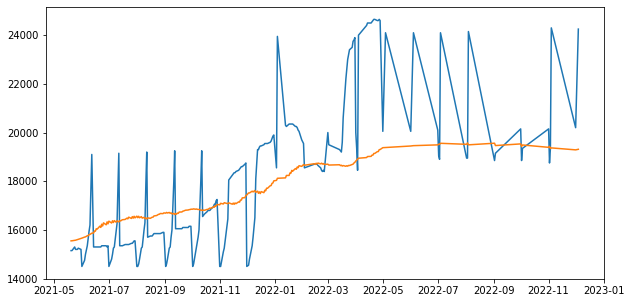

In [ ]:
prediction1_a1 = forecast_predict(model1_a, test_minyakgoreng_, time_size=win_size1, batch_size=5)

data_result1_a1 = prediction1_a1[(len(x_train))-win_size1:-1, -1 ]
data_result1_a1 = scal_range.inverse_transform(data_result1_a1.reshape(-1, 1))
data_result1_a1 = data_result1_a1.reshape(-1)
mae1_a1 = tf.keras.metrics.mean_absolute_error(x_test, data_result1_a1)
mape1_a1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1_a1)
mse1_a1 = tf.keras.metrics.mean_squared_error(x_test, data_result1_a1)

rmse1_a1 = math.sqrt(mse1_a1.numpy())
print(mae1_a1.numpy(), mape1_a1.numpy(), rmse1_a1)

data_new_minyakgoreng1_a1 = pd.DataFrame()
data_new_minyakgoreng1_a1['actual'] = x_test
data_new_minyakgoreng1_a1['prediction'] = data_result1_a1
data_new_minyakgoreng1_a1.to_csv('minyakgoreng_model2_sgd_type2.csv')

plt.figure(figsize=(10, 5))
plt.plot(y_test, data_new_minyakgoreng1_a1.actual)
plt.plot(y_test, data_new_minyakgoreng1_a1.prediction)
data_new_minyakgoreng1_a1

#### Type 3

In [ ]:
history1_a2 = model1_a.fit(train_step2, epochs=15, validation_data=val_step)

Epoch 1/15
84/84 [==============================] - 2s 18ms/step - loss: 0.0129 - mae: 0.0933 - mape: 49.6881 - val_loss: 0.0217 - val_mae: 0.1126 - val_mape: 43.6059
Epoch 2/15
84/84 [==============================] - 2s 17ms/step - loss: 0.0119 - mae: 0.0847 - mape: 41.4283 - val_loss: 0.0211 - val_mae: 0.1052 - val_mape: 39.5473
Epoch 3/15
84/84 [==============================] - 2s 17ms/step - loss: 0.0116 - mae: 0.0821 - mape: 38.5738 - val_loss: 0.0211 - val_mae: 0.1052 - val_mape: 39.5757
Epoch 4/15
84/84 [==============================] - 2s 17ms/step - loss: 0.0115 - mae: 0.0810 - mape: 37.6864 - val_loss: 0.0211 - val_mae: 0.1047 - val_mape: 39.3015
Epoch 5/15
84/84 [==============================] - 2s 17ms/step - loss: 0.0113 - mae: 0.0807 - mape: 37.6858 - val_loss: 0.0211 - val_mae: 0.1049 - val_mape: 39.3754
Epoch 6/15
84/84 [==============================] - 2s 17ms/step - loss: 0.0111 - mae: 0.0796 - mape: 36.7529 - val_loss: 0.0211 - val_mae: 0.1050 - val_mape: 39.409

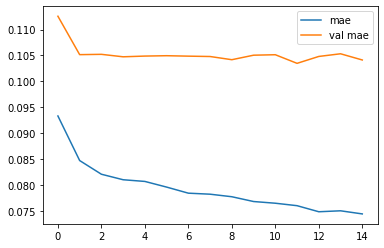

In [60]:
mae1_a2 = history1_a2.history['mae']
val_mae1_a2 = history1_a2.history['val_mae']
epoch1_a2 = range(len(mae1_a2))

plt.plot(epoch1_a2, mae1_a2, label='mae')
plt.plot(epoch1_a2, val_mae1_a2, label='val mae')
plt.legend()
plt.show()

181/181 [==============================] - 1s 5ms/step
1405.3846 7.066761 2076.4314339751263


,actual,prediction
0,15150,14789.179688
1,15150,14791.466797
2,15300,14803.880859
3,15200,14808.502930
4,15200,14828.138672
...,...,...
229,18750,19633.830078
230,19350,19531.193359
231,24300,19562.003906
232,20200,19463.869141


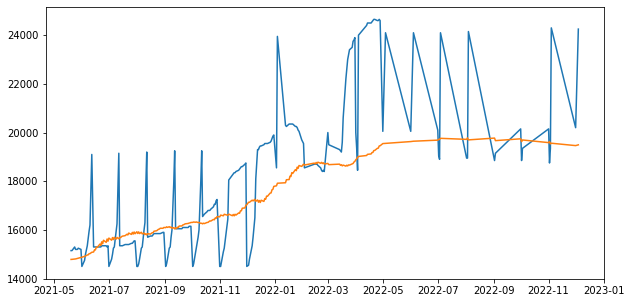

In [61]:
prediction1_a2 = forecast_predict(model1_a, test_minyakgoreng_, time_size=win_size2, batch_size=5)

data_result1_a2 = prediction1_a2[(len(x_train))-win_size2:-1, -1 ]
data_result1_a2 = scal_range.inverse_transform(data_result1_a2.reshape(-1, 1))
data_result1_a2 = data_result1_a2.reshape(-1)
mae1_a2 = tf.keras.metrics.mean_absolute_error(x_test, data_result1_a2)
mape1_a2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1_a2)
mse1_a2 = tf.keras.metrics.mean_squared_error(x_test, data_result1_a2)

rmse1_a2 = math.sqrt(mse1_a2.numpy())
print(mae1_a2.numpy(), mape1_a2.numpy(), rmse1_a2)

data_new_minyakgoreng1_a2 = pd.DataFrame()
data_new_minyakgoreng1_a2['actual'] = x_test
data_new_minyakgoreng1_a2['prediction'] = data_result1_a2
data_new_minyakgoreng1_a2.to_csv('minyakgoreng_model2_sgd_type3.csv')

plt.figure(figsize=(10, 5))
plt.plot(y_test, data_new_minyakgoreng1_a2.actual)
plt.plot(y_test, data_new_minyakgoreng1_a2.prediction)

data_new_minyakgoreng1_a2

## model 2

### SGD

In [62]:
model2= Sequential([
    Conv1D(8, kernel_size=5, 
                            activation='relu',strides=2,
                            padding='causal', input_shape=[None, 1]),
    tf.keras.layers.MaxPool1D(2, padding="same"),
    LSTM(14, return_sequences=True),
    Dropout(0.3),
    LSTM(64),
    Dense(24, activation='relu'),
    Dense(550, activation='relu'),
    Dense(1)
])

model2.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9), loss='mse', metrics=['mae', 'mape'])
model2.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_5 (Conv1D)           (None, None, 8)           48        
                                                                 
 max_pooling1d_1 (MaxPooling  (None, None, 8)          0         
 1D)                                                             
                                                                 
 lstm_10 (LSTM)              (None, None, 14)          1288      
                                                                 
 dropout_1 (Dropout)         (None, None, 14)          0         
                                                                 
 lstm_11 (LSTM)              (None, 64)                20224     
                                                                 
 dense_13 (Dense)            (None, 24)                1560      
                                                      

In [ ]:
# plot_model(model2, to_file='model3_plot.png', show_shapes=True, show_layer_names=True)

#### Type 1

In [66]:
history2 = model2.fit(train_step, epochs=50, validation_data=val_step)

Epoch 1/50
44/44 [==============================] - 1s 18ms/step - loss: 0.0109 - mae: 0.0842 - mape: 18.8426 - val_loss: 0.0470 - val_mae: 0.2052 - val_mape: 91.0499
Epoch 2/50
44/44 [==============================] - 1s 15ms/step - loss: 0.0108 - mae: 0.0842 - mape: 18.8427 - val_loss: 0.0471 - val_mae: 0.2054 - val_mape: 91.1244
Epoch 3/50
44/44 [==============================] - 1s 15ms/step - loss: 0.0109 - mae: 0.0841 - mape: 18.8050 - val_loss: 0.0470 - val_mae: 0.2050 - val_mape: 90.9548
Epoch 4/50
44/44 [==============================] - 1s 15ms/step - loss: 0.0109 - mae: 0.0843 - mape: 18.8988 - val_loss: 0.0471 - val_mae: 0.2052 - val_mape: 91.0515
Epoch 5/50
44/44 [==============================] - 1s 15ms/step - loss: 0.0109 - mae: 0.0840 - mape: 18.7616 - val_loss: 0.0470 - val_mae: 0.2051 - val_mape: 90.9714
Epoch 6/50
44/44 [==============================] - 1s 16ms/step - loss: 0.0109 - mae: 0.0840 - mape: 18.7748 - val_loss: 0.0470 - val_mae: 0.2050 - val_mape: 90.944

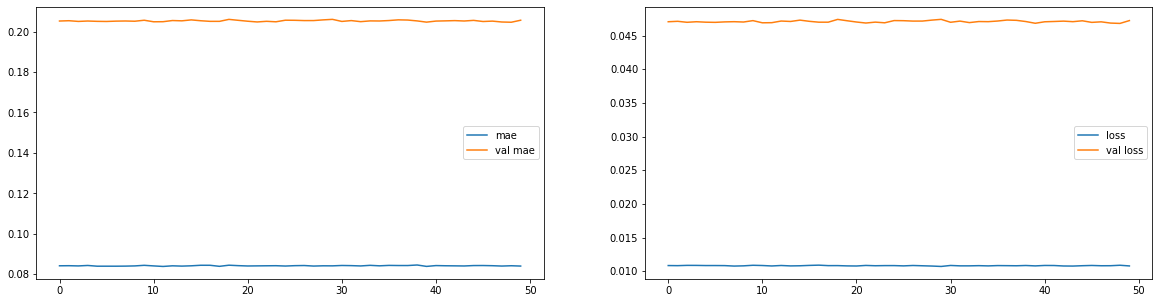

In [67]:
mae2 = history2.history['mae']
val_mae2 = history2.history['val_mae']
loss2 = history2.history['loss']
val_loss2 = history2.history['val_loss']
epoch2 = range(len(mae2))

plt.figure(figsize=(20, 5))
plt.subplot(1,2, 1)
plt.plot(epoch2, mae2, label='mae')
plt.plot(epoch2, val_mae2, label='val mae')
plt.legend()
plt.subplot(1,2,2)
plt.plot(epoch2, loss2, label='loss')
plt.plot(epoch2, val_loss2, label='val loss')
plt.legend()
plt.show()

131/131 [==============================] - 1s 6ms/step
2324.944 12.867363 2803.120404121093


,actual,prediction
0,15150,17890.662109
1,15150,17890.632812
2,15300,17891.601562
3,15200,17890.968750
4,15200,17893.380859
...,...,...
229,18750,18226.933594
230,19350,18233.599609
231,24300,18232.943359
232,20200,18231.050781


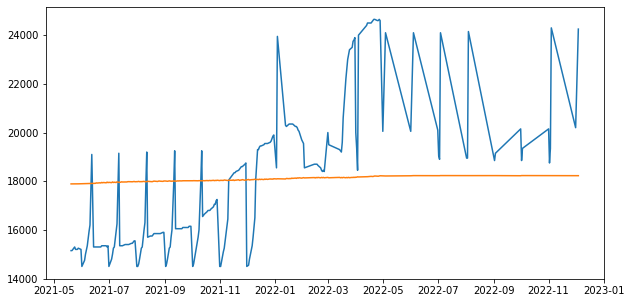

In [68]:
prediction2 = forecast_predict(model2, test_minyakgoreng_, time_size=win_size, batch_size=5)

data_result2 = prediction2[(len(x_train))-win_size:-1, -1 ]
data_result2 = scal_range.inverse_transform(data_result2.reshape(-1, 1))
data_result2 = data_result2.reshape(-1)
mae2 = tf.keras.metrics.mean_absolute_error(x_test, data_result2)
mape2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2)
mse2 = tf.keras.metrics.mean_squared_error(x_test, data_result2)

rmse2 = math.sqrt(mse2.numpy())
print(mae2.numpy(), mape2.numpy(), rmse2)

data_new_minyakgoreng2 = pd.DataFrame()
data_new_minyakgoreng2['actual'] = x_test
data_new_minyakgoreng2['prediction'] = data_result2
data_new_minyakgoreng2.to_csv('minyakgoreng_medium_model3_sgd_type1.csv')

plt.figure(figsize=(10, 5))
plt.plot(y_test, data_new_minyakgoreng2.actual)
plt.plot(y_test, data_new_minyakgoreng2.prediction)
data_new_minyakgoreng2

#### Type2

In [69]:
history2_1 = model2.fit(train_step1, epochs=50, validation_data=val_step)

Epoch 1/50
718/718 [==============================] - 6s 8ms/step - loss: 0.0226 - mae: 0.1249 - mape: 535927.1875 - val_loss: 0.0261 - val_mae: 0.1410 - val_mape: 58.9944
Epoch 2/50
718/718 [==============================] - 6s 8ms/step - loss: 0.0194 - mae: 0.1134 - mape: 409273.2188 - val_loss: 0.0252 - val_mae: 0.1373 - val_mape: 57.0391
Epoch 3/50
718/718 [==============================] - 6s 8ms/step - loss: 0.0190 - mae: 0.1116 - mape: 327715.7500 - val_loss: 0.0258 - val_mae: 0.1395 - val_mape: 58.2420
Epoch 4/50
718/718 [==============================] - 6s 8ms/step - loss: 0.0188 - mae: 0.1120 - mape: 332207.7188 - val_loss: 0.0259 - val_mae: 0.1401 - val_mape: 58.5154
Epoch 5/50
718/718 [==============================] - 6s 8ms/step - loss: 0.0186 - mae: 0.1102 - mape: 336044.6562 - val_loss: 0.0258 - val_mae: 0.1396 - val_mape: 58.2525
Epoch 6/50
718/718 [==============================] - 6s 8ms/step - loss: 0.0181 - mae: 0.1089 - mape: 409063.8438 - val_loss: 0.0263 - val_

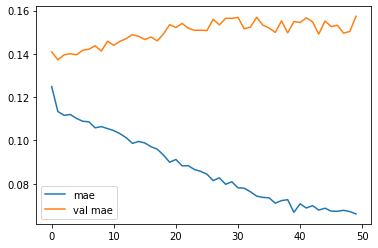

In [70]:
mae2_1 = history2_1.history['mae']
val_mae2_1 = history2_1.history['val_mae']
epoch2_1 = range(len(mae2_1))

plt.plot(epoch2_1, mae2_1, label='mae')
plt.plot(epoch2_1, val_mae2_1, label='val mae')
plt.legend()
plt.show()

In [71]:
prediction2_1 = forecast_predict(model2, test_minyakgoreng_, time_size=win_size1, batch_size=5)

data_result2_1 = prediction2_1[(len(x_train))-win_size1:-1, -1 ]
data_result2_1 = scal_range.inverse_transform(data_result2_1.reshape(-1, 1))
data_result2_1 = data_result2_1.reshape(-1)
mae2_1 = tf.keras.metrics.mean_absolute_error(x_test, data_result2_1)
mape2_1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2_1)
mse2_1 = tf.keras.metrics.mean_squared_error(x_test, data_result2_1)

rmse2_1 = math.sqrt(mse2_1.numpy())
print(mae2_1.numpy(), mape2_1.numpy(), rmse2_1)

data_new_minyakgoreng2_1 = pd.DataFrame()
data_new_minyakgoreng2_1['actual'] = x_test
data_new_minyakgoreng2_1['prediction'] = data_result2_1
data_new_minyakgoreng2_1.to_csv('minyakgoreng_model3_sgd_type2.csv')

data_new_minyakgoreng2

199/199 [==============================] - 1s 4ms/step
1550.643 7.993759 2183.843858887352


,actual,prediction
0,15150,17890.662109
1,15150,17890.632812
2,15300,17891.601562
3,15200,17890.968750
4,15200,17893.380859
...,...,...
229,18750,18226.933594
230,19350,18233.599609
231,24300,18232.943359
232,20200,18231.050781


#### Type 3

In [72]:
history2_2 = model2.fit(train_step2, epochs=50, validation_data=val_step)

Epoch 1/50
84/84 [==============================] - 1s 12ms/step - loss: 0.0132 - mae: 0.0954 - mape: 48.5942 - val_loss: 0.0256 - val_mae: 0.1370 - val_mape: 56.6312
Epoch 2/50
84/84 [==============================] - 1s 12ms/step - loss: 0.0123 - mae: 0.0855 - mape: 39.5682 - val_loss: 0.0242 - val_mae: 0.1299 - val_mape: 52.8793
Epoch 3/50
84/84 [==============================] - 1s 12ms/step - loss: 0.0121 - mae: 0.0830 - mape: 37.0660 - val_loss: 0.0243 - val_mae: 0.1302 - val_mape: 53.0618
Epoch 4/50
84/84 [==============================] - 1s 11ms/step - loss: 0.0120 - mae: 0.0824 - mape: 36.5812 - val_loss: 0.0244 - val_mae: 0.1306 - val_mape: 53.2411
Epoch 5/50
84/84 [==============================] - 1s 12ms/step - loss: 0.0120 - mae: 0.0834 - mape: 37.3174 - val_loss: 0.0242 - val_mae: 0.1294 - val_mape: 52.5885
Epoch 6/50
84/84 [==============================] - 1s 12ms/step - loss: 0.0119 - mae: 0.0829 - mape: 37.0439 - val_loss: 0.0243 - val_mae: 0.1302 - val_mape: 53.029

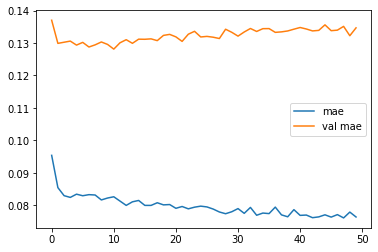

In [73]:
mae2_2 = history2_2.history['mae']
val_mae2_2 = history2_2.history['val_mae']
epoch2_2 = range(len(mae2_2))

plt.plot(epoch2_2, mae2_2, label='mae')
plt.plot(epoch2_2, val_mae2_2, label='val mae')
plt.legend()
plt.show()

In [74]:
prediction2_2 = forecast_predict(model2, test_minyakgoreng_, time_size=win_size2, batch_size=5)

data_result2_2 = prediction2_2[(len(x_train))-win_size2:-1, -1 ]
data_result2_2 = scal_range.inverse_transform(data_result2_2.reshape(-1, 1))
data_result2_2 = data_result2_2.reshape(-1)
mae2_2 = tf.keras.metrics.mean_absolute_error(x_test, data_result2_2)
mape2_2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2_2)
mse2_2 = tf.keras.metrics.mean_squared_error(x_test, data_result2_2)

rmse2_2 = math.sqrt(mse2_2.numpy())
print(mae2_2.numpy(), mape2_2.numpy(), rmse2_2)

data_new_minyakgoreng2_2 = pd.DataFrame()
data_new_minyakgoreng2_2['actual'] = x_test
data_new_minyakgoreng2_2['prediction'] = data_result2_2
data_new_minyakgoreng2_2.to_csv('minyakgoreng_model3_sgd-type3.csv')

data_new_minyakgoreng2_2

181/181 [==============================] - 1s 4ms/step
1396.6127 7.0104523 2089.114046671459


,actual,prediction
0,15150,14685.340820
1,15150,14684.673828
2,15300,14686.971680
3,15200,14686.682617
4,15200,14689.437500
...,...,...
229,18750,19461.353516
230,19350,19384.986328
231,24300,19397.769531
232,20200,19411.451172


### Adam

In [75]:
model2_a= Sequential([
    Conv1D(16, kernel_size=2, 
                            activation='relu',strides=2,
                            padding='causal', input_shape=[None, 1]),
    tf.keras.layers.MaxPool1D(2, padding="same"),
    LSTM(24, return_sequences=True),
    Dropout(0.3),
    LSTM(80),
    Dense(24, activation='relu'),
    Dense(50, activation='relu'),
    Dense(1)
])

model2_a.compile(loss= 'mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), metrics=['mae', 'mape'])
model2_a.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, None, 16)          48        
                                                                 
 max_pooling1d_2 (MaxPooling  (None, None, 16)         0         
 1D)                                                             
                                                                 
 lstm_12 (LSTM)              (None, None, 24)          3936      
                                                                 
 dropout_2 (Dropout)         (None, None, 24)          0         
                                                                 
 lstm_13 (LSTM)              (None, 80)                33600     
                                                                 
 dense_16 (Dense)            (None, 24)                1944      
                                                      

#### type 1

In [76]:
history2_a = model2_a.fit(train_step, epochs=50, validation_data=val_step)

Epoch 1/50
44/44 [==============================] - 4s 34ms/step - loss: 0.1648 - mae: 0.3923 - mape: 88.2282 - val_loss: 0.0530 - val_mae: 0.1828 - val_mape: 61.0857
Epoch 2/50
44/44 [==============================] - 1s 17ms/step - loss: 0.0507 - mae: 0.1975 - mape: 44.9245 - val_loss: 0.0228 - val_mae: 0.1239 - val_mape: 49.5924
Epoch 3/50
44/44 [==============================] - 1s 15ms/step - loss: 0.0156 - mae: 0.1019 - mape: 23.5280 - val_loss: 0.0218 - val_mae: 0.1174 - val_mape: 46.2031
Epoch 4/50
44/44 [==============================] - 1s 16ms/step - loss: 0.0160 - mae: 0.1032 - mape: 23.7966 - val_loss: 0.0217 - val_mae: 0.1168 - val_mape: 45.9129
Epoch 5/50
44/44 [==============================] - 1s 16ms/step - loss: 0.0137 - mae: 0.0945 - mape: 21.5779 - val_loss: 0.0225 - val_mae: 0.1221 - val_mape: 48.7614
Epoch 6/50
44/44 [==============================] - 1s 16ms/step - loss: 0.0128 - mae: 0.0930 - mape: 21.2480 - val_loss: 0.0222 - val_mae: 0.1205 - val_mape: 47.919

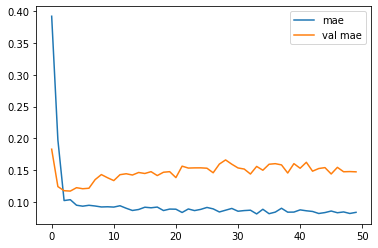

In [77]:
mae2_a = history2_a.history['mae']
val_mae2_a = history2_a.history['val_mae']
epoch2_a = range(len(mae2_a))

plt.plot(epoch2_a, mae2_a, label='mae')
plt.plot(epoch2_a, val_mae2_a, label='val mae')
plt.legend()
plt.show()

In [78]:
prediction2_a = forecast_predict(model2_a, test_minyakgoreng_, time_size=win_size, batch_size=5)

data_result2_a = prediction2_a[(len(x_train))-win_size:-1, -1 ]
data_result2_a = scal_range.inverse_transform(data_result2_a.reshape(-1, 1))
data_result2_a = data_result2_a.reshape(-1)
mae2_a = tf.keras.metrics.mean_absolute_error(x_test, data_result2_a)
mape2_a = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2_a)
mse2_a = tf.keras.metrics.mean_squared_error(x_test, data_result2_a)

rmse2_a = math.sqrt(mse2_a.numpy())
print(mae2_a.numpy(), mape2_a.numpy(), rmse2_a)

data_new_minyakgoreng2_a = pd.DataFrame()
data_new_minyakgoreng2_a['actual'] = x_test
data_new_minyakgoreng2_a['prediction'] = data_result2_a
data_new_minyakgoreng2_a.to_csv('minyakgoreng_model3_adam-type1.csv')

data_new_minyakgoreng2_a

131/131 [==============================] - 2s 6ms/step
1930.5146 10.650004 2382.056044680729


,actual,prediction
0,15150,17128.667969
1,15150,17125.376953
2,15300,17137.701172
3,15200,17140.476562
4,15200,17149.542969
...,...,...
229,18750,19295.246094
230,19350,19306.777344
231,24300,19362.125000
232,20200,19263.636719


#### Type 2

In [79]:
history2_a1 = model2_a.fit(train_step1, epochs=50, validation_data=val_step)

Epoch 1/50
718/718 [==============================] - 6s 8ms/step - loss: 0.0105 - mae: 0.0762 - mape: 378815.8125 - val_loss: 0.0384 - val_mae: 0.1817 - val_mape: 79.4789
Epoch 2/50
718/718 [==============================] - 6s 8ms/step - loss: 0.0089 - mae: 0.0701 - mape: 366855.3438 - val_loss: 0.0277 - val_mae: 0.1459 - val_mape: 61.2489
Epoch 3/50
718/718 [==============================] - 6s 8ms/step - loss: 0.0084 - mae: 0.0650 - mape: 347283.4688 - val_loss: 0.0313 - val_mae: 0.1588 - val_mape: 68.0107
Epoch 4/50
718/718 [==============================] - 6s 8ms/step - loss: 0.0083 - mae: 0.0640 - mape: 319121.5000 - val_loss: 0.0208 - val_mae: 0.1019 - val_mape: 37.7358
Epoch 5/50
718/718 [==============================] - 5s 8ms/step - loss: 0.0081 - mae: 0.0626 - mape: 315038.2500 - val_loss: 0.0292 - val_mae: 0.1506 - val_mape: 63.7081
Epoch 6/50
718/718 [==============================] - 6s 8ms/step - loss: 0.0078 - mae: 0.0619 - mape: 302851.0312 - val_loss: 0.0245 - val_

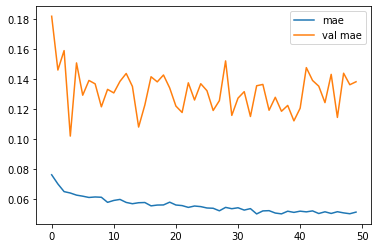

In [80]:
mae2_a1 = history2_a1.history['mae']
val_mae2_a1 = history2_a1.history['val_mae']
epoch2_a1 = range(len(mae2_a1))

plt.plot(epoch2_a1, mae2_a1, label='mae')
plt.plot(epoch2_a1, val_mae2_a1, label='val mae')
plt.legend()
plt.show()

199/199 [==============================] - 1s 3ms/step
1517.7799 8.210276 1876.8843198236805


,actual,prediction
0,15150,14439.959961
1,15150,14440.001953
2,15300,14444.864258
3,15200,14450.461914
4,15200,14463.168945
...,...,...
229,18750,20991.708984
230,19350,20955.111328
231,24300,21136.421875
232,20200,20871.189453


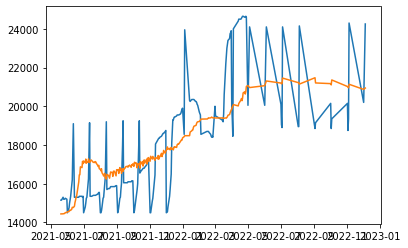

In [81]:
prediction2_a1 = forecast_predict(model2_a, test_minyakgoreng_, time_size=win_size1, batch_size=5)

data_result2_a1 = prediction2_a1[(len(x_train))-win_size1:-1, -1 ]
data_result2_a1 = scal_range.inverse_transform(data_result2_a1.reshape(-1, 1))
data_result2_a1 = data_result2_a1.reshape(-1)
mae2_a1 = tf.keras.metrics.mean_absolute_error(x_test, data_result2_a1)
mape2_a1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2_a1)
mse2_a1 = tf.keras.metrics.mean_squared_error(x_test, data_result2_a1)

rmse2_a1 = math.sqrt(mse2_a1.numpy())
print(mae2_a1.numpy(), mape2_a1.numpy(), rmse2_a1)

data_new_minyakgoreng2_a1 = pd.DataFrame()
data_new_minyakgoreng2_a1['actual'] = x_test
data_new_minyakgoreng2_a1['prediction'] = data_result2_a1
data_new_minyakgoreng2_a1.to_csv('minyakgoreng_model3_adam-type2.csv')

plt.plot(y_test, data_new_minyakgoreng2_a1.actual)
plt.plot(y_test, data_new_minyakgoreng2_a1.prediction)
data_new_minyakgoreng2_a1

#### Type 3

In [82]:
history2_a2 = model2_a.fit(train_step2, epochs= 50, validation_data=val_step)

Epoch 1/50
84/84 [==============================] - 1s 14ms/step - loss: 0.0078 - mae: 0.0572 - mape: 20.0138 - val_loss: 0.0240 - val_mae: 0.1216 - val_mape: 48.2537
Epoch 2/50
84/84 [==============================] - 1s 12ms/step - loss: 0.0075 - mae: 0.0547 - mape: 18.3747 - val_loss: 0.0234 - val_mae: 0.1179 - val_mape: 46.2722
Epoch 3/50
84/84 [==============================] - 1s 12ms/step - loss: 0.0074 - mae: 0.0543 - mape: 17.9895 - val_loss: 0.0238 - val_mae: 0.1209 - val_mape: 47.9027
Epoch 4/50
84/84 [==============================] - 1s 12ms/step - loss: 0.0075 - mae: 0.0558 - mape: 19.1324 - val_loss: 0.0235 - val_mae: 0.1191 - val_mape: 46.9131
Epoch 5/50
84/84 [==============================] - 1s 12ms/step - loss: 0.0071 - mae: 0.0535 - mape: 18.0671 - val_loss: 0.0237 - val_mae: 0.1210 - val_mape: 47.9533
Epoch 6/50
84/84 [==============================] - 1s 12ms/step - loss: 0.0072 - mae: 0.0539 - mape: 18.7485 - val_loss: 0.0240 - val_mae: 0.1227 - val_mape: 48.863

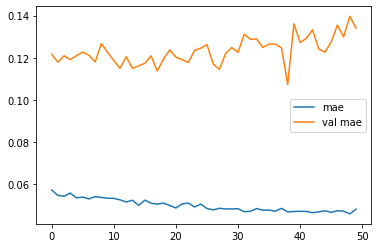

In [83]:
mae2_a2 = history2_a2.history['mae']
val_mae2_a2 = history2_a2.history['val_mae']
epoch2_a2 = range(len(mae2_a2))

plt.plot(epoch2_a2, mae2_a2, label='mae')
plt.plot(epoch2_a2, val_mae2_a2, label='val mae')
plt.legend()
plt.show()

181/181 [==============================] - 1s 4ms/step
1534.6316 8.205641 1988.4007392877322


,actual,prediction
0,15150,15387.874023
1,15150,15653.344727
2,15300,15400.310547
3,15200,15929.293945
4,15200,15685.391602
...,...,...
229,18750,20424.722656
230,19350,20271.724609
231,24300,20264.314453
232,20200,20262.248047


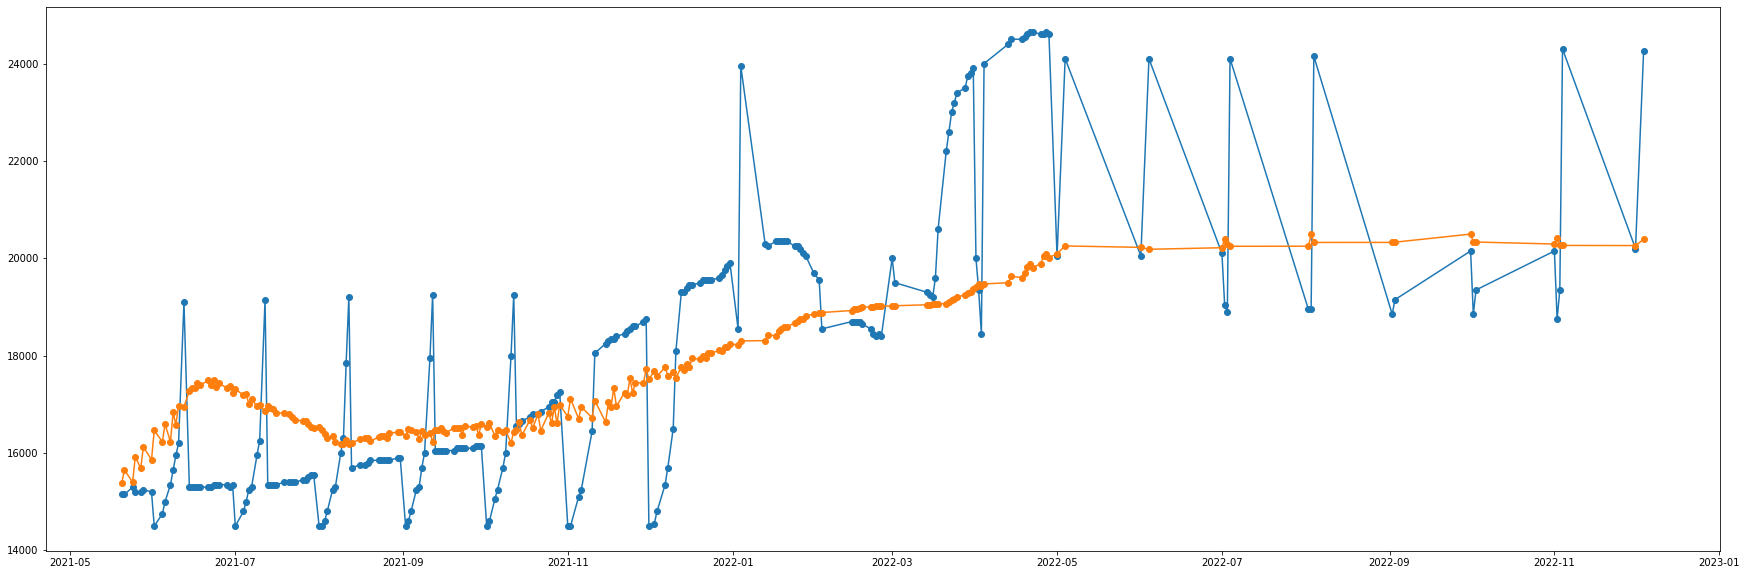

In [84]:
prediction2_a2 = forecast_predict(model2_a, test_minyakgoreng_, time_size=win_size2, batch_size=5)

data_result2_a2 = prediction2_a2[(len(x_train))-win_size2:-1, -1 ]
data_result2_a2 = scal_range.inverse_transform(data_result2_a2.reshape(-1, 1))
data_result2_a2 = data_result2_a2.reshape(-1)
mae2_a2 = tf.keras.metrics.mean_absolute_error(x_test, data_result2_a2)
mape2_a2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2_a2)
mse2_a2 = tf.keras.metrics.mean_squared_error(x_test, data_result2_a2)

rmse2_a2 = math.sqrt(mse2_a2.numpy())
print(mae2_a2.numpy(), mape2_a2.numpy(), rmse2_a2)

data_new_minyakgoreng2_a2 = pd.DataFrame()
data_new_minyakgoreng2_a2['actual'] = x_test
data_new_minyakgoreng2_a2['prediction'] = data_result2_a2
data_new_minyakgoreng2_a2.to_csv('minyakgoreng_model3_adam_type3.csv')

plt.figure(figsize=(30, 10))
plt.plot(y_test,data_new_minyakgoreng2_a2.actual, '-o')
plt.plot(y_test,data_new_minyakgoreng2_a2.prediction, '-o')
data_new_minyakgoreng2_a2